In [8]:
from __future__ import print_function
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import time
import h5py
from pathlib import Path
import os

from art.attacks import CarliniL2Method, CarliniLInfMethod
from art.classifiers import PyTorchClassifier
from art.utils import load_mnist

%matplotlib inline
%config InlineBackend.figure_format='retina'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
# Step 1: Load the MNIST dataset

(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

# Step 1a: Swap axes to PyTorch's NCHW format

x_train = np.swapaxes(x_train, 1, 3).astype(np.float32)
x_test = np.swapaxes(x_test, 1, 3).astype(np.float32)

# Create dataloaders

train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
train_dataloader = DataLoader(train_dataset, batch_size=64)

test_dataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
test_dataloader = DataLoader(test_dataset, batch_size=1000)
test_dataloader_single =  DataLoader(test_dataset, batch_size=1)

In [10]:
path = Path("C:/Users/Matach/OneDrive - Imperial College London/ICL/FYP/Experiments/saved_models/MNIST/Carlini/Adversarial PGD/regularisation")
file = "L2_1e-03.pth"
pretrained_model = os.path.join(path, file)
use_cuda = True

In [11]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 512)
        self.fc2 = nn.Linear(512, 200)
        self.fc3 = nn.Linear(200,10)
        

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return x
    
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the model.
model = Classifier().to(device)

# Load pre-trained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
print(model.eval())

# Load loss and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

# Make a classifier wrapper!
classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)

# Test model
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {} %".format(accuracy * 100))

CUDA Available:  True
Classifier(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=10, bias=True)
)
Accuracy on benign test examples: 96.92 %


In [12]:
# Generate adversarial test examples
def CarliniL2(classifier, x_test, init_const):
    attack = CarliniL2Method(classifier=classifier,
                            confidence=0.0,
                            targeted=False,
                            learning_rate=0.01,
                            binary_search_steps=2,
                            initial_const=init_const,
                            batch_size=64)
    x_test_adv = attack.generate(x=x_test)

    return x_test_adv

def CarliniLInf(classifier, x_test, epsilon):
    attack = CarliniLInfMethod(classifier=classifier, 
                              confidence=0.0,
                              targeted=False, 
                              learning_rate=0.01,
                              eps=epsilon, 
                              batch_size=128)
    x_test_adv = attack.generate(x=x_test)
    
    return x_test_adv

# Calculate distance 
def L2distance(x_test, x_test_adv):
    dist = 0
    samples_changed = 0
    for test, adv_test in zip(x_test, x_test_adv):
        l2 = np.linalg.norm(test-adv_test)
        dist += l2
        samples_changed = samples_changed + 1 if l2>0 else samples_changed
    dist /= samples_changed
    return dist

### L2

In [13]:
carlini_l2 = dict()
constants = [0.1, 0.5, 1.0, 2.5, 5, 10, 15, 20, 25, 30, 40]
n = 1000
accuracies = []
distances = []
for init in constants:
    x_test_adv = CarliniL2(classifier, x_test[:n], init_const=init)
    predictions = classifier.predict(x_test_adv)
    acc = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:n], axis=1)) / n
    accuracies.append(round(acc, 3))
    dist = L2distance(x_test[:n], x_test_adv)
    distances.append(round(dist, 3))

    print('c:', init, ' Accuracy:', acc, ' Distance:', round(distances[-1], 3))

c: 0.1  Accuracy: 0.961  Distance: 0.123
c: 0.5  Accuracy: 0.935  Distance: 0.47
c: 1.0  Accuracy: 0.921  Distance: 0.675
c: 2.5  Accuracy: 0.847  Distance: 1.333
c: 5  Accuracy: 0.745  Distance: 1.989
c: 10  Accuracy: 0.6  Distance: 2.802
c: 15  Accuracy: 0.505  Distance: 3.244
c: 20  Accuracy: 0.449  Distance: 3.506
c: 25  Accuracy: 0.404  Distance: 3.696
c: 30  Accuracy: 0.368  Distance: 3.858
c: 40  Accuracy: 0.336  Distance: 3.987


In [14]:
accuracies

[0.961, 0.935, 0.921, 0.847, 0.745, 0.6, 0.505, 0.449, 0.404, 0.368, 0.336]

In [15]:
distances

[0.123, 0.47, 0.675, 1.333, 1.989, 2.802, 3.244, 3.506, 3.696, 3.858, 3.987]

### LInf

In [16]:
epsilons = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
n = 1000
accuracies = []
for eps in epsilons:
    x_test_adv = CarliniLInf(classifier, x_test[:n], epsilon=eps)
    predictions = classifier.predict(x_test_adv)
    acc = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:n], axis=1)) / n
    accuracies.append(round(acc, 3))

    print('eps:', eps, ' Accuracy:', acc)

print(accuracies)

eps: 0.01  Accuracy: 0.955
eps: 0.1  Accuracy: 0.956
eps: 0.2  Accuracy: 0.918
eps: 0.3  Accuracy: 0.827
eps: 0.4  Accuracy: 0.704
eps: 0.5  Accuracy: 0.532
eps: 0.6  Accuracy: 0.369
eps: 0.7  Accuracy: 0.274
eps: 0.8  Accuracy: 0.277
eps: 0.9  Accuracy: 0.266
eps: 1  Accuracy: 0.272
[0.955, 0.956, 0.918, 0.827, 0.704, 0.532, 0.369, 0.274, 0.277, 0.266, 0.272]


## Results

In [54]:
adv_train = {
    'Baseline model': [0.973, 0.789, 0.532, 0.212, 0.106, 0.064, .064, .064, .064, .064, .064],
    'PGD adversarial model': [0.9565, 0.943 , 0.926 , 0.872 , 0.796 , 0.673 , 0.571, 0.495, 0.435, 0.399, 0.374]
}

adv_dist_train = {
    'Baseline model': [0.271, 1.275, 2.017, 2.692, 3.117, 3.46, 3.633, 3.734, 3.786, 3.863, 3.942], 
    'PGD adversarial model': [0.1415, 0.3725, 0.5885, 1.108 , 1.7875, 2.586, 3.122, 3.377, 3.592, 3.728, 3.967],
}

adv_eps_train = {
    'Baseline model':  [0.987, 0.929, 0.780, 0.568, 0.368, 0.197, 0.108, .064, .064, .064, .064],
    'PGD adversarial model': [0.957, 0.95 , 0.914, 0.855, 0.757, 0.595, 0.415, 0.272, 0.258, 0.26, 0.262],
}

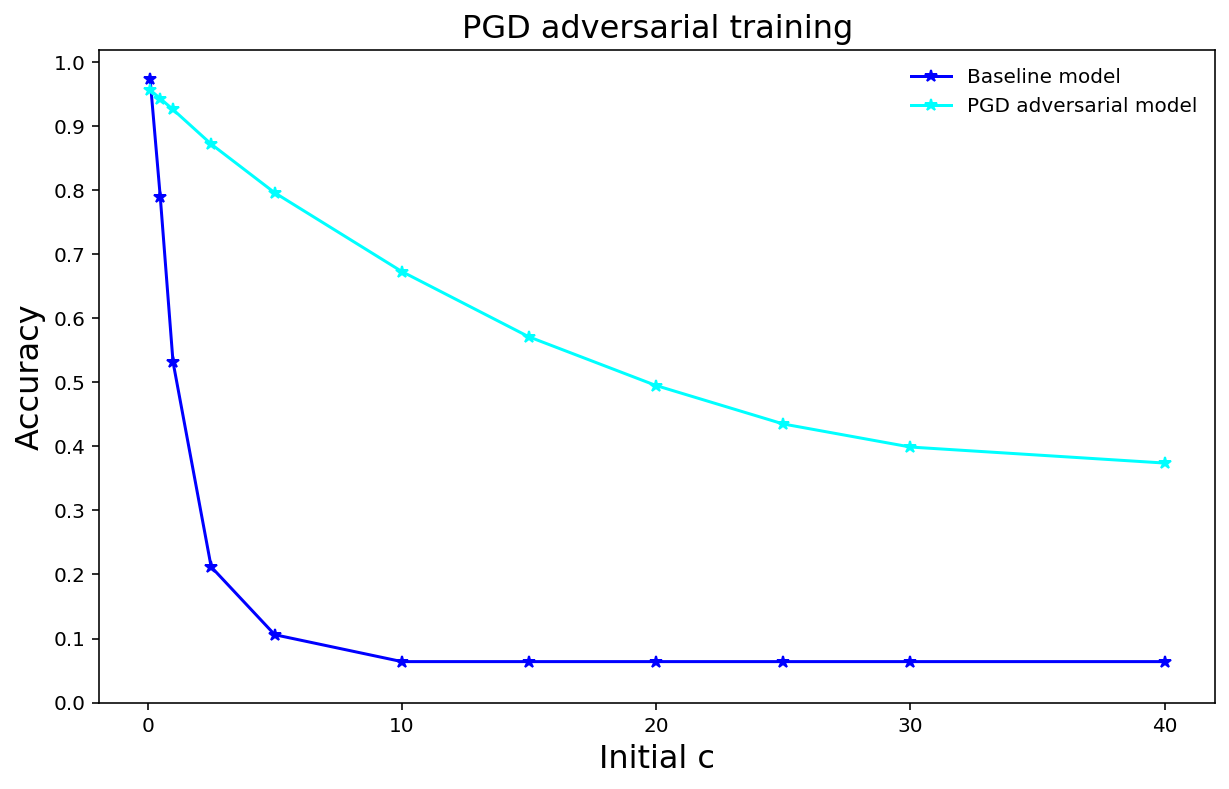

In [28]:
plt.figure(figsize=(10,6))
colors =  ['blue', 'cyan']
constants = [0.1, 0.5, 1.0, 2.5, 5, 10, 15, 20, 25, 30, 40]

for idx, (title, results) in enumerate(adv_train.items()):
    plt.plot(constants, results, "*-", color=colors[idx], label="{}".format(title))

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 40.1, step=10))
plt.title("PGD adversarial training",fontsize=16)
plt.xlabel("Initial c",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='upper right', frameon=False)
plt.show()

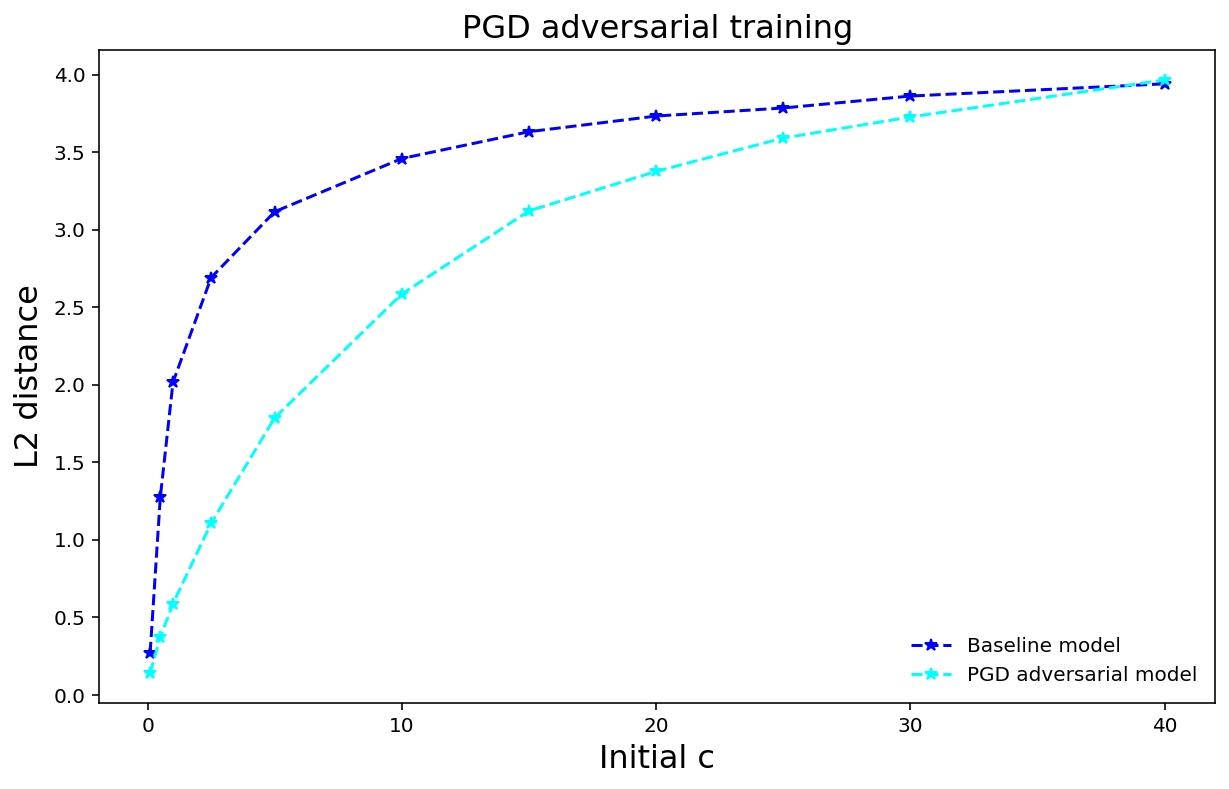

In [56]:
# plot the distances vs constant c

plt.figure(figsize=(10,6))
colors =  ['blue', 'cyan']

for idx, (title, results) in enumerate(adv_dist_train.items()):
    plt.plot(constants, results, "*--", color=colors[idx], label="{}".format(title))

# plt.yticks(np.arange(0, 3.6, step=0.5))
plt.xticks(np.arange(0, 40.1, step=10))
plt.title("PGD adversarial training",fontsize=16)
plt.xlabel("Initial c",fontsize=16)
plt.ylabel("L2 distance",fontsize=16)
plt.legend(loc='lower right', frameon=False)
plt.show()

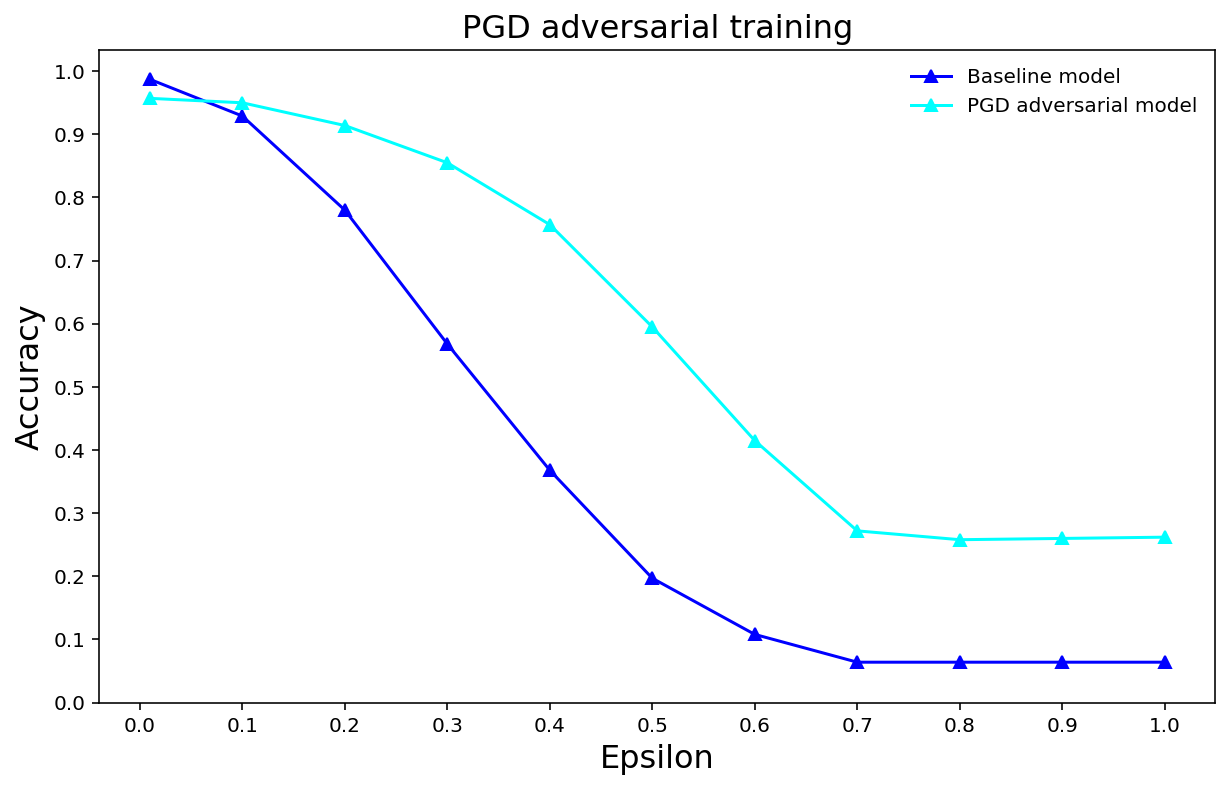

In [27]:
# plot the pruned accuracies vs epsilon
epsilons = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]


plt.figure(figsize=(10,6))
colors =  ['blue', 'cyan']

for idx, (title, results) in enumerate(adv_eps_train.items()):
    plt.plot(epsilons, results, "^-", color=colors[idx], label="{}".format(title))

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.title("PGD adversarial training",fontsize=16)
plt.xlabel("Epsilon",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='upper right', frameon=False)
plt.show()

### Quantised PGD model

In [3]:
adv_qat = {
    'Baseline model': [0.973, 0.789, 0.532, 0.212, 0.106, 0.064, .064, .064, .064, .064, .064],
    'PGD adversarial model': [0.9565, 0.943 , 0.926 , 0.872 , 0.796 , 0.673 , 0.571, 0.495, 0.435, 0.399, 0.374],
    'QAT adversarial model': [0.9635, 0.942 , 0.916 , 0.853 , 0.7275, 0.532 , 0.437 , 0.3855, 0.349 , 0.33  , 0.2995]
}


adv_dist_qat = {
    'Baseline model': [0.271, 1.275, 2.017, 2.692, 3.117, 3.46, 3.633, 3.734, 3.786, 3.863, 3.942], 
    'PGD adversarial model': [0.1415, 0.3725, 0.5885, 1.108 , 1.7875, 2.586, 3.122, 3.377, 3.592, 3.728, 3.967],
    'QAT adversarial model': [0.134 , 0.4195, 0.715 , 1.3225, 2.172 , 3.1295, 3.5175, 3.7255, 3.867 , 3.975 , 4.149 ]
}

adv_eps_qat = {
    'Baseline model':  [0.987, 0.929, 0.780, 0.568, 0.368, 0.197, 0.108, .064, .064, .064, .064],
    'PGD adversarial model': [0.957, 0.95 , 0.914, 0.855, 0.757, 0.595, 0.415, 0.272, 0.258, 0.26, 0.262],
    'QAT adversarial model': [0.9635, 0.9525, 0.9145, 0.838 , 0.7095, 0.538 , 0.3745, 0.2535, 0.253 , 0.2545, 0.2435]
}

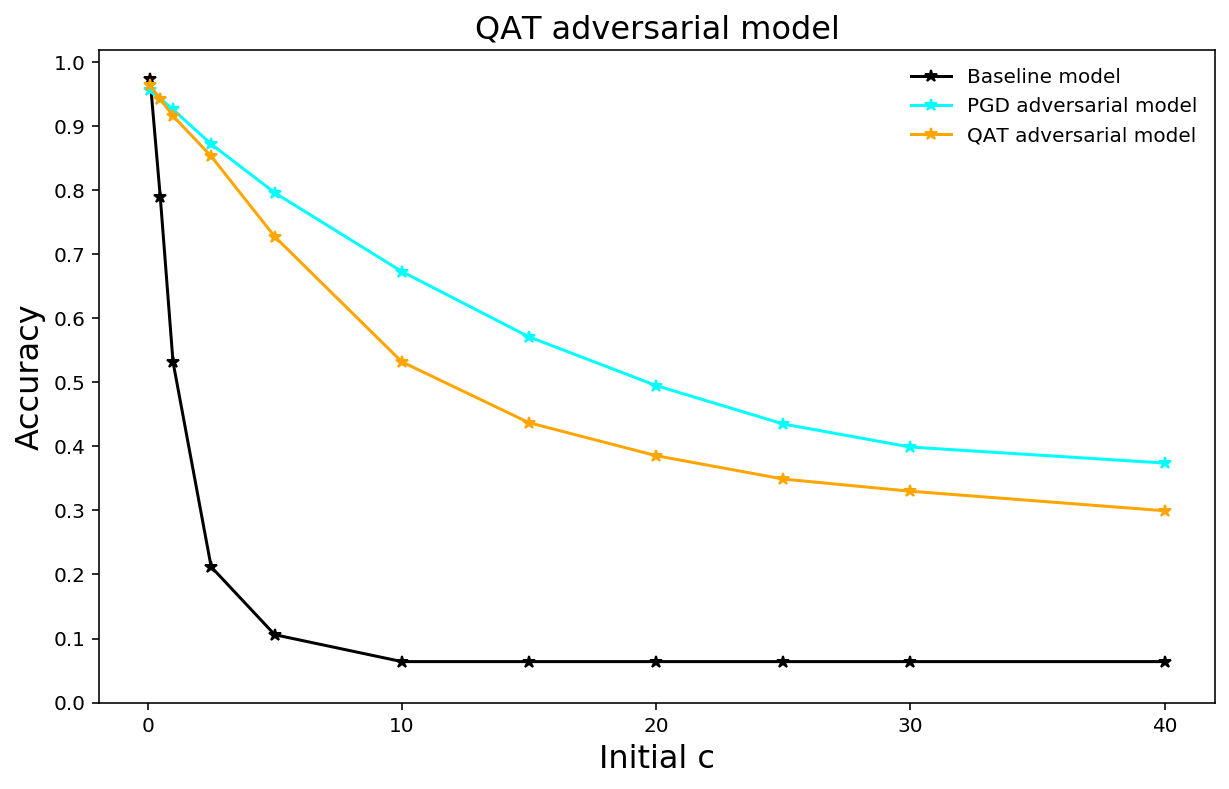

In [4]:
plt.figure(figsize=(10,6))
colors =  ['black', 'cyan', 'orange']
constants = [0.1, 0.5, 1.0, 2.5, 5, 10, 15, 20, 25, 30, 40]

for idx, (title, results) in enumerate(adv_qat.items()):
    plt.plot(constants, results, "*-", color=colors[idx], label="{}".format(title))

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 40.1, step=10))
plt.title("QAT adversarial model",fontsize=16)
plt.xlabel("Initial c",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='upper right', frameon=False)
plt.show()

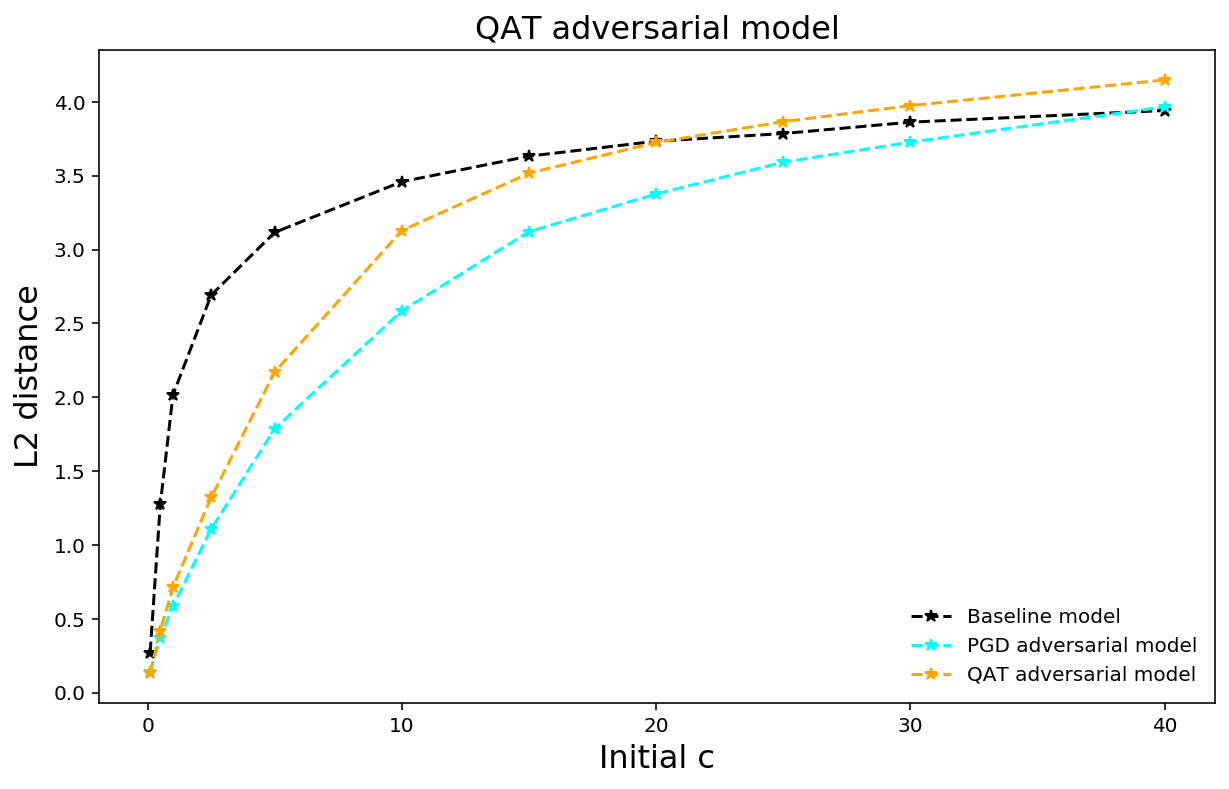

In [6]:
# plot the distances vs constant c

plt.figure(figsize=(10,6))
colors =  ['black', 'cyan', 'orange']

for idx, (title, results) in enumerate(adv_dist_qat.items()):
    plt.plot(constants, results, "*--", color=colors[idx], label="{}".format(title))

# plt.yticks(np.arange(0, 3.6, step=0.5))
plt.xticks(np.arange(0, 40.1, step=10))
plt.title("QAT adversarial model",fontsize=16)
plt.xlabel("Initial c",fontsize=16)
plt.ylabel("L2 distance",fontsize=16)
plt.legend(loc='lower right', frameon=False)
plt.show()

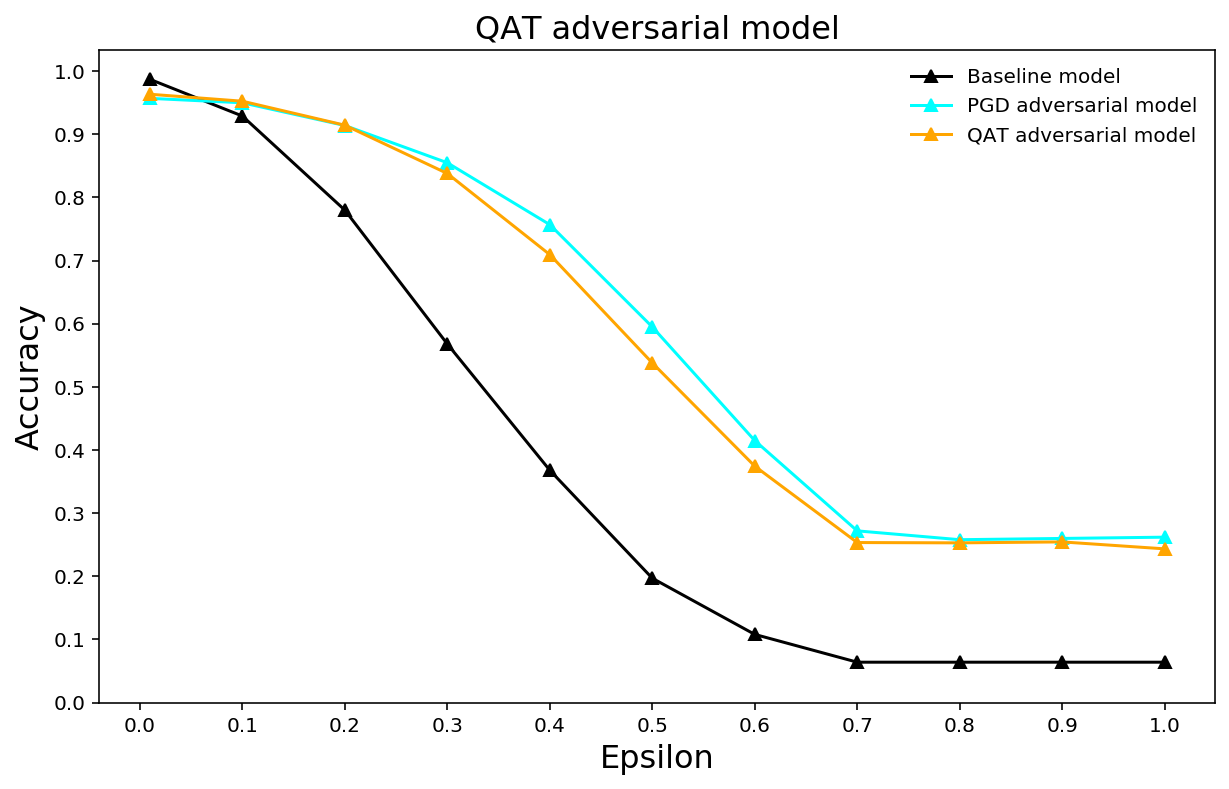

In [7]:
# plot the pruned accuracies vs epsilon
epsilons = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]


plt.figure(figsize=(10,6))
colors =  ['black', 'cyan', 'orange']

for idx, (title, results) in enumerate(adv_eps_qat.items()):
    plt.plot(epsilons, results, "^-", color=colors[idx], label="{}".format(title))

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.title("QAT adversarial model",fontsize=16)
plt.xlabel("Epsilon",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='upper right', frameon=False)
plt.show()

### Regularised PGD model

In [20]:
adv_regu = {
    'Baseline model': [0.973, 0.789, 0.532, 0.212, 0.106, 0.064, .064, .064, .064, .064, .064],
    'PGD adversarial model': [0.9565, 0.943 , 0.926 , 0.872 , 0.796 , 0.673 , 0.571, 0.495, 0.435, 0.399, 0.374],
    '1e-02': [0.933, 0.908, 0.867, 0.78, 0.647, 0.468, 0.396, 0.347, 0.324, 0.309, 0.301] , 
    '1e-03': [0.961, 0.935, 0.921, 0.847, 0.745, 0.6, 0.505, 0.449, 0.404, 0.368, 0.336],
    '1e-04': [0.95, 0.944, 0.922, 0.85, 0.717, 0.548, 0.451, 0.395, 0.357, 0.343, 0.313],
}

adv_dist_regu = {
    'Baseline model': [0.271, 1.275, 2.017, 2.692, 3.117, 3.46, 3.633, 3.734, 3.786, 3.863, 3.942], 
    'PGD adversarial model': [0.1415, 0.3725, 0.5885, 1.108 , 1.7875, 2.586, 3.122, 3.377, 3.592, 3.728, 3.967],
    '1e-02':[0.096, 0.367, 0.624, 1.145, 1.805, 2.6, 2.934, 3.186, 3.32, 3.464, 3.516],
    '1e-03': [0.123, 0.47, 0.675, 1.333, 1.989, 2.802, 3.244, 3.506, 3.696, 3.858, 3.987],
    '1e-04': [0.129, 0.372, 0.689, 1.383, 2.284, 3.138, 3.508, 3.777, 3.965, 4.052, 4.251],
}

adv_eps_regu = {
    'Baseline model':  [0.987, 0.929, 0.780, 0.568, 0.368, 0.197, 0.108, .064, .064, .064, .064],
    'PGD adversarial model': [0.957, 0.95 , 0.914, 0.855, 0.757, 0.595, 0.415, 0.272, 0.258, 0.26, 0.262],
    '1e-02':[0.937, 0.905, 0.838, 0.718, 0.568, 0.423, 0.33, 0.274, 0.253, 0.26, 0.252],
    '1e-03': [0.955, 0.956, 0.918, 0.827, 0.704, 0.532, 0.369, 0.274, 0.277, 0.266, 0.272],
    '1e-04': [0.957, 0.951, 0.923, 0.851, 0.724, 0.559, 0.387, 0.278, 0.277, 0.26, 0.258],
}

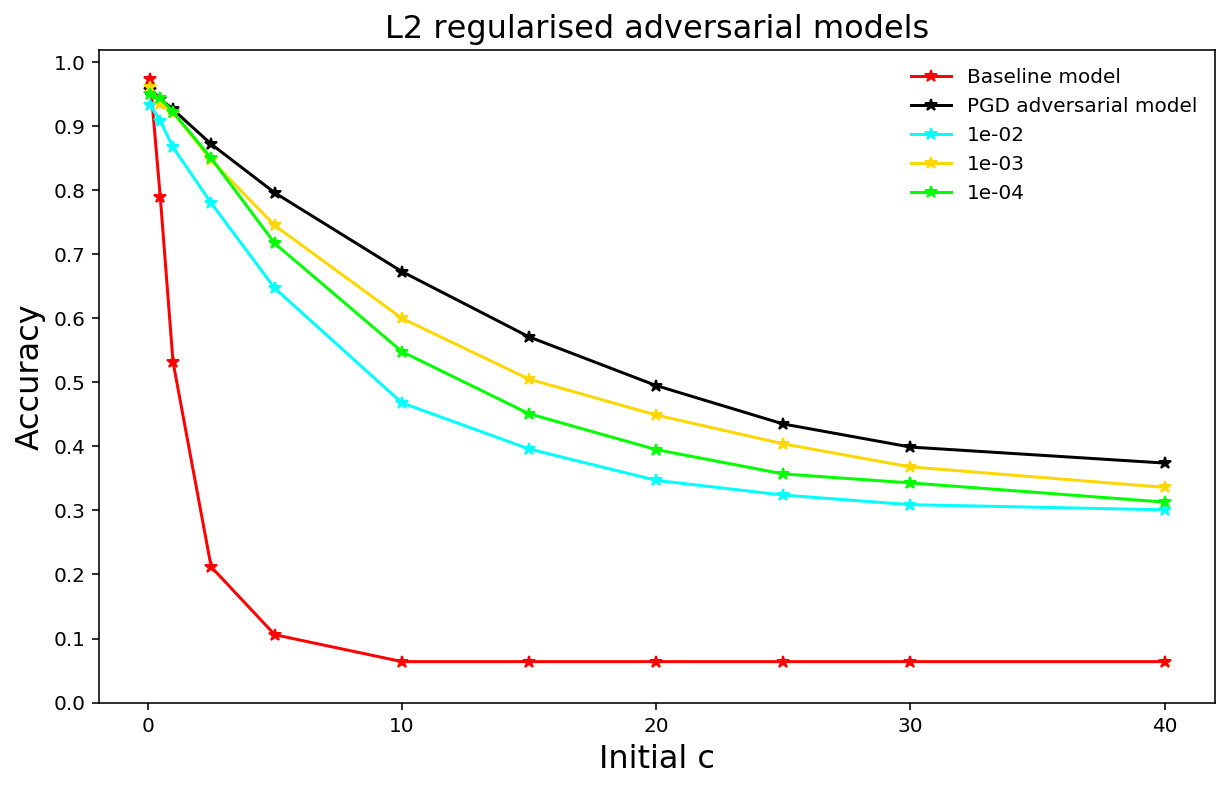

In [21]:
plt.figure(figsize=(10,6))
colors =  ['red', 'black', 'cyan', 'gold', 'lime']
constants = [0.1, 0.5, 1.0, 2.5, 5, 10, 15, 20, 25, 30, 40]

for idx, (title, results) in enumerate(adv_regu.items()):
    plt.plot(constants, results, "*-", color=colors[idx], label="{}".format(title))

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 40.1, step=10))
plt.title("L2 regularised adversarial models",fontsize=16)
plt.xlabel("Initial c",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='upper right', frameon=False)
plt.show()

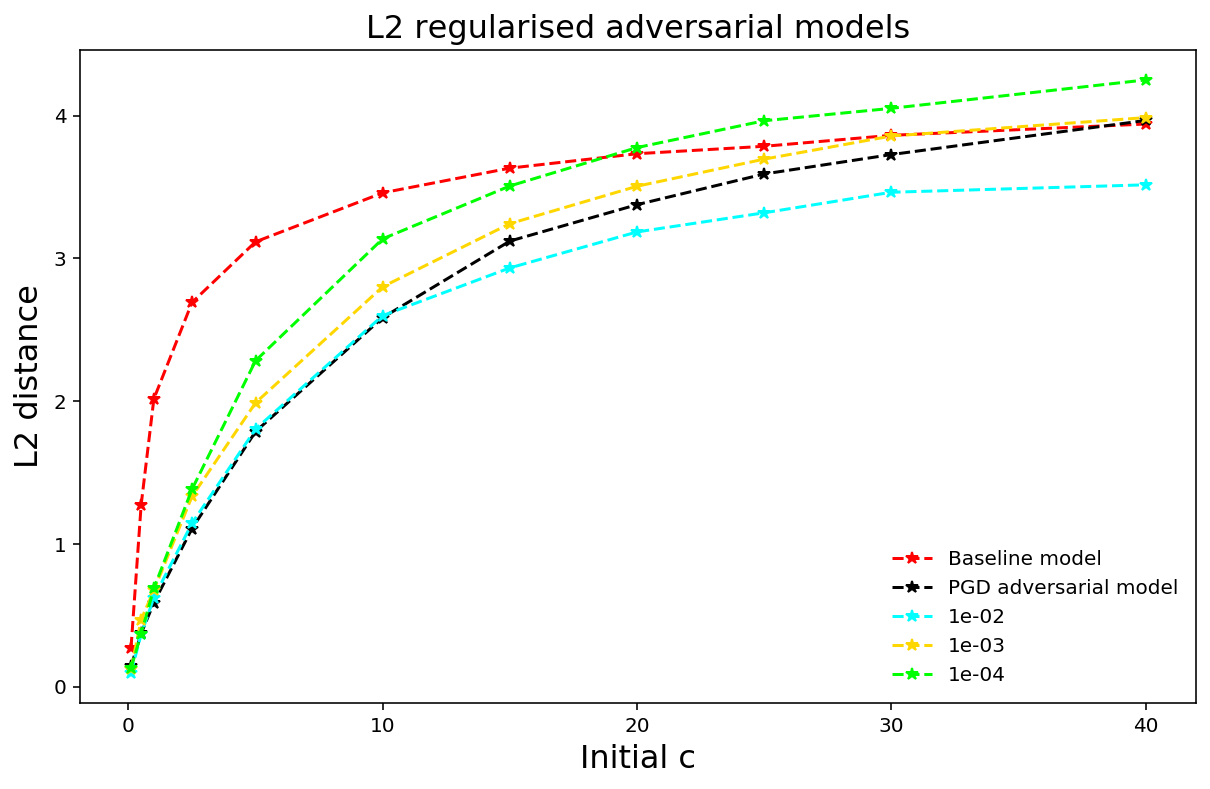

In [22]:
# plot the distances vs constant c

plt.figure(figsize=(10,6))
colors =  ['red', 'black', 'cyan', 'gold', 'lime']

for idx, (title, results) in enumerate(adv_dist_regu.items()):
    plt.plot(constants, results, "*--", color=colors[idx], label="{}".format(title))

# plt.yticks(np.arange(0, 3.6, step=0.5))
plt.xticks(np.arange(0, 40.1, step=10))
plt.title("L2 regularised adversarial models",fontsize=16)
plt.xlabel("Initial c",fontsize=16)
plt.ylabel("L2 distance",fontsize=16)
plt.legend(loc='lower right', frameon=False)
plt.show()

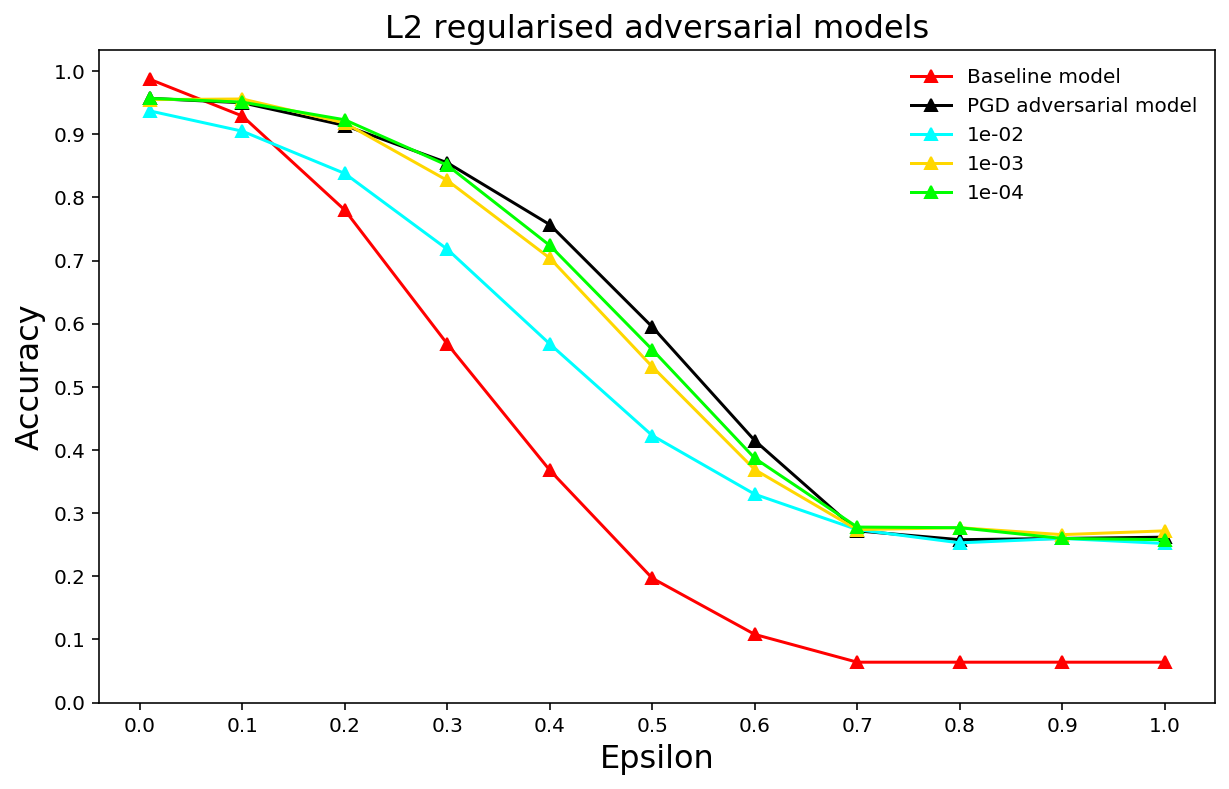

In [23]:
# plot the pruned accuracies vs epsilon
epsilons = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]


plt.figure(figsize=(10,6))
colors =  ['red', 'black', 'cyan', 'gold', 'lime']

for idx, (title, results) in enumerate(adv_eps_regu.items()):
    plt.plot(epsilons, results, "^-", color=colors[idx], label="{}".format(title))

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.title("L2 regularised adversarial models",fontsize=16)
plt.xlabel("Epsilon",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='upper right', frameon=False)
plt.show()